In [ ]:
pip install tensorflow tensorflow-model-optimization

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.mixed_precision import set_global_policy
import tensorflow_model_optimization as tfmot
import numpy as np
from google.colab import drive
import json

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Enable mixed precision training globally
print("Configuring mixed precision...")
set_global_policy('mixed_float16')

# Configure memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

def preprocess(x):
    return (x / 127.5) - 1.0

def deprocess(x):
    return (x + 1.0) * 0.5

class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(PixelShuffle, self).get_config()
        config.update({"scale": self.scale})
        return config

class OptimizedDataLoader:
    def __init__(self, ufo_path, custom_path, batch_size=2):
        self.batch_size = batch_size
        self.ufo_path = ufo_path
        self.custom_path = custom_path
        self.image_res = (360, 640)
        self.autotune = tf.data.AUTOTUNE
        print("Initializing OptimizedDataLoader...")
        self.build_datasets()

    @tf.function(experimental_relax_shapes=True)
    def load_and_preprocess_image(self, path, is_mask=False):
        img = tf.io.read_file(path)
        if is_mask:
            img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)
        else:
            img = tf.image.decode_png(img, channels=3, dtype=tf.uint8)

        img = tf.image.resize(img, self.image_res, method='bilinear')
        img = tf.cast(img, tf.float32)

        if not is_mask:
            img = preprocess(img)
        else:
            img = img / 255.0

        return tf.cast(img, tf.float16)

    def build_datasets(self):
        print("Building optimized datasets...")

        # List and cache files
        lrd_files = tf.data.Dataset.list_files([
            os.path.join(self.ufo_path, "lrd", "*.*"),
            os.path.join(self.custom_path, "lrd", "*.*")
        ], shuffle=False).cache()

        hr_files = tf.data.Dataset.list_files([
            os.path.join(self.ufo_path, "hr", "*.*"),
            os.path.join(self.custom_path, "hr", "*.*")
        ], shuffle=False).cache()

        mask_files = tf.data.Dataset.list_files([
            os.path.join(self.ufo_path, "mask", "*.*"),
            os.path.join(self.custom_path, "mask", "*.*")
        ], shuffle=False).cache()

        # Count total samples
        total_samples = sum(1 for _ in lrd_files)
        print(f"Total samples found: {total_samples}")

        # Create dataset
        dataset = tf.data.Dataset.zip((lrd_files, hr_files, mask_files))
        dataset = dataset.shuffle(buffer_size=min(5000, total_samples))

        # Split dataset
        val_size = int(0.1 * total_samples)
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)

        @tf.function
        def process_path(lrd, hr, mask):
            input_img = self.load_and_preprocess_image(lrd)
            mask_img = self.load_and_preprocess_image(mask, is_mask=True)
            hr_img = self.load_and_preprocess_image(hr)

            # Return as tuple of (input, (output1, output2, output3))
            return input_img, (mask_img, hr_img, hr_img)

        # Create final datasets
        self.train_dataset = (
            train_dataset.map(process_path, num_parallel_calls=self.autotune)
            .cache()
            .shuffle(1000)
            .batch(self.batch_size)
            .prefetch(self.autotune)
        )

        self.val_dataset = (
            val_dataset.map(process_path, num_parallel_calls=self.autotune)
            .cache()
            .batch(self.batch_size)
            .prefetch(self.autotune)
        )

        print(f"Datasets built - Train samples: {total_samples - val_size}, Validation samples: {val_size}")

        # Verify dataset structure
        for x, y in self.train_dataset.take(1):
            print("\nDataset structure:")
            print("Input shape:", x.shape)
            print("Output shapes:", [y_i.shape for y_i in y])

    def get_train_dataset(self):
        return self.train_dataset

    def get_val_dataset(self):
        return self.val_dataset

def residual_dense_block(x, filters, kernel_size):
    for _ in range(3):
        y = layers.Conv2D(filters, kernel_size, padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        x = layers.Concatenate()([x, y])
    return layers.Conv2D(filters, 1, padding='same')(x)



def create_deep_sesr_640x360():
    print("Creating model architecture...")
    input_img = layers.Input(shape=(360, 640, 3), name='input_image')

    # Feature Extraction Network
    branch_3x3 = input_img
    branch_5x5 = input_img

    for i in range(8):
        branch_3x3 = residual_dense_block(branch_3x3, 64, 3)
        branch_5x5 = residual_dense_block(branch_5x5, 64, 5)

    features = layers.Concatenate()([branch_3x3, branch_5x5])

    for i in range(4):
        features = residual_dense_block(features, 64, 3)

    features = layers.Conv2D(32, 1, padding='same', name='features')(features)

    # Auxiliary Attention Network
    saliency = layers.Conv2D(64, 3, padding='same', activation='relu')(features)
    saliency = layers.Conv2D(1, 3, padding='same', activation='sigmoid', name='saliency')(saliency)

    # Enhancement branch
    enhanced = layers.Conv2D(64, 3, padding='same', activation='relu')(features)
    enhanced = layers.Conv2D(3, 3, padding='same', activation='tanh', name='enhanced')(enhanced)

    # Super-resolution branch
    sr = layers.Conv2D(64, 3, padding='same', activation='relu')(enhanced)
    sr = layers.Conv2D(64, 3, padding='same', activation='relu')(sr)
    sr = layers.Conv2D(256, 3, padding='same', activation='relu')(sr)

    sr = PixelShuffle(2)(sr)

    sr = layers.Conv2D(64, 3, padding='same', activation='relu')(sr)
    sr = layers.Conv2D(64, 3, padding='same', activation='relu')(sr)
    sr_output = layers.Conv2D(3, 3, padding='same', activation='tanh')(sr)
    final_output = layers.AveragePooling2D(2, name='final_output')(sr_output)

    return tf.keras.Model(inputs=input_img, outputs=[saliency, enhanced, final_output], name='deep_sesr')

def create_quantized_model():
    """Create a quantization-aware model"""
    # Define quantization configuration
    quantize_config = {
        'quantize_layer_type': 'per_channel',
        'quantize_activation_type': 'per_tensor',
        'quantize_weight_bits': 8,
        'quantize_activation_bits': 8
    }

    # Create the model with quantization layers
    with tfmot.quantization.keras.quantize_scope(quantize_config):
        model = create_deep_sesr_640x360()

    return model

def apply_quantization_to_model(model, representative_dataset):
    """Apply post-training quantization with proper converter settings"""
    print("Applying post-training quantization...")

    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Set optimization flags
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Set representative dataset
    converter.representative_dataset = representative_dataset

    # Enable full integer quantization
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
        tf.lite.OpsSet.TFLITE_BUILTINS,
    ]

    # Force input/output to specific types
    converter.inference_input_type = tf.float32  # Changed from uint8
    converter.inference_output_type = tf.float32  # Changed from uint8

    # Add additional converter settings
    converter.experimental_new_converter = True
    converter.experimental_new_quantizer = True

    # Allow custom operations
    converter.allow_custom_ops = True

    # Enable debugging
    converter.debug_mode = True

    return converter.convert()

def train_model(ufo_path, custom_path, epochs=50, batch_size=2):
    output_dir = "/content/drive/MyDrive/Data/OutputDeepSESR"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nModel outputs will be saved to: {output_dir}")

    data_loader = OptimizedDataLoader(ufo_path, custom_path, batch_size)
    train_dataset = data_loader.get_train_dataset()
    val_dataset = data_loader.get_val_dataset()

    # Verify dataset structure
    for x, y in train_dataset.take(1):
        print("Input shape:", x.shape)
        print("Output shapes:", [y_i.shape for y_i in y])

    strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()

    with strategy.scope():
        # Create model
        model = create_deep_sesr_640x360()

        # Use mixed precision optimizer
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
            optimizers.Adam(learning_rate=1e-4)
        )

        model.compile(
            optimizer=optimizer,
            loss=['binary_crossentropy', 'mse', 'mse'],
            loss_weights=[0.1, 0.3, 0.6]
        )

    print("\nStarting training...")
    # Ensure dataset is properly structured for training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        steps_per_epoch=None,  # Will be automatically calculated
        validation_steps=None,  # Will be automatically calculated
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(output_dir, "deep_sesr_640x360_best.keras"),
                save_best_only=True,
                monitor='val_loss',
                save_freq='epoch'
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(output_dir, "deep_sesr_640x360_epoch_{epoch:02d}.keras"),
                save_freq='epoch'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.TensorBoard(
                log_dir=os.path.join(output_dir, 'logs'),
                histogram_freq=1,
                update_freq='epoch'
            )
        ],
        verbose=1
    )

    # Save models
    print("\nSaving models...")
    model.save_weights(os.path.join(output_dir, "deep_sesr_640x360_final.weights.h5"))
    model.save(os.path.join(output_dir, "deep_sesr_640x360_final.keras"))

    # Save training history
    history_path = os.path.join(output_dir, "training_history.json")
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

    print("\nSaved files in output directory:")
    for file in os.listdir(output_dir):
        print(f"- {file}")

    return history, model

if __name__ == "__main__":
    print("\n=== Deep SESR Training Pipeline ===\n")

    ufo_path = "/content/drive/MyDrive/Data/UFO-150"
    custom_path = "/content/drive/MyDrive/Data/Custom"

    if not os.path.exists(ufo_path):
        raise ValueError(f"UFO dataset path not found: {ufo_path}")
    if not os.path.exists(custom_path):
        raise ValueError(f"Custom dataset path not found: {custom_path}")

    try:
        history, model = train_model(
            ufo_path=ufo_path,
            custom_path=custom_path,
            epochs=50,
            batch_size=2
        )
        print("\nTraining completed successfully!")
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

Configuring mixed precision...
Memory growth enabled for GPUs

=== Deep SESR Training Pipeline ===


Model outputs will be saved to: /content/drive/MyDrive/Data/OutputDeepSESR
Initializing OptimizedDataLoader...
Building optimized datasets...
Total samples found: 1833
Datasets built - Train samples: 1650, Validation samples: 183

Dataset structure:
Input shape: (2, 360, 640, 3)
Output shapes: [TensorShape([2, 360, 640, 1]), TensorShape([2, 360, 640, 3]), TensorShape([2, 360, 640, 3])]
Input shape: (2, 360, 640, 3)
Output shapes: [TensorShape([2, 360, 640, 1]), TensorShape([2, 360, 640, 3]), TensorShape([2, 360, 640, 3])]
Creating model architecture...

Starting training...
Epoch 1/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 577s 269ms/step - loss: 0.1399 - val_loss: 0.0928 - learning_rate: 1.0000e-04
Epoch 2/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 200s 243ms/step - loss: 0.0980 - val_loss: 0.0885 - learning_rate: 1.0000e-04
Epoch 3/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 201s 243ms/step - loss: 0.0912 - val_loss:

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

@tf.keras.utils.register_keras_serializable()
class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(PixelShuffle, self).get_config()
        config.update({"scale": self.scale})
        return config

def preprocess(x):
    return (x / 127.5) - 1.0

def deprocess(x):
    return (x + 1.0) * 0.5

def load_and_preprocess_image(image_path, target_size=(360, 640)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]))
    img = img.astype(np.float32)
    img = preprocess(img)
    return img

def save_image(path, image, is_saliency=False):
    """Save image with proper dtype conversion"""
    # Convert to uint8 for saving
    if is_saliency:
        # For saliency map, scale to 0-255 range
        image = (image * 255).astype(np.uint8)
        # Use cv2 to save grayscale image
        cv2.imwrite(path, image)
    else:
        # For RGB images
        image = (image * 255).astype(np.uint8)
        # Convert from RGB to BGR for cv2
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path, image)

def process_directory():
    # Define paths
    model_path = "/content/drive/MyDrive/Data/OutputDeepSESR/deep_sesr_640x360_final.keras"
    input_dir = "/content/drive/MyDrive/Data/Test"
    output_dir = "/content/drive/MyDrive/Data/Results"

    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "saliency"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "enhanced"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "final"), exist_ok=True)

    # Load model
    print("Loading model...")
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'PixelShuffle': PixelShuffle}
        )
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

    # Get list of images
    image_files = [f for f in os.listdir(input_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

    if not image_files:
        print(f"No images found in {input_dir}")
        return

    print(f"\nFound {len(image_files)} images to process")

    # Process each image
    for idx, filename in enumerate(image_files, 1):
        try:
            print(f"\nProcessing image {idx}/{len(image_files)}: {filename}")

            # Load and preprocess image
            image_path = os.path.join(input_dir, filename)
            test_image = load_and_preprocess_image(image_path)
            test_image = np.expand_dims(test_image, axis=0)

            # Run inference
            saliency_map, enhanced_image, final_output = model.predict(
                test_image,
                verbose=0
            )

            # Deprocess outputs
            enhanced_image = deprocess(enhanced_image[0])
            final_output = deprocess(final_output[0])
            saliency_map = saliency_map[0, ..., 0]

            # Clip values
            enhanced_image = np.clip(enhanced_image, 0, 1)
            final_output = np.clip(final_output, 0, 1)
            saliency_map = np.clip(saliency_map, 0, 1)

            # Save results
            base_name = os.path.splitext(filename)[0]

            # Save each output using cv2
            save_image(
                os.path.join(output_dir, "saliency", f'{base_name}_saliency.png'),
                saliency_map,
                is_saliency=True
            )
            save_image(
                os.path.join(output_dir, "enhanced", f'{base_name}_enhanced.png'),
                enhanced_image
            )
            save_image(
                os.path.join(output_dir, "final", f'{base_name}_final.png'),
                final_output
            )

            # Save comparison image
            comparison = np.zeros((test_image.shape[1], test_image.shape[2]*4, 3), dtype=np.uint8)

            # Original image
            original_image = deprocess(test_image[0])
            original_image = (original_image * 255).astype(np.uint8)
            comparison[:, :test_image.shape[2]] = original_image

            # Saliency map (convert to RGB)
            saliency_rgb = cv2.applyColorMap(
                (saliency_map * 255).astype(np.uint8),
                cv2.COLORMAP_JET
            )
            comparison[:, test_image.shape[2]:test_image.shape[2]*2] = saliency_rgb

            # Enhanced image
            enhanced_uint8 = (enhanced_image * 255).astype(np.uint8)
            comparison[:, test_image.shape[2]*2:test_image.shape[2]*3] = enhanced_uint8

            # Final output
            final_uint8 = (final_output * 255).astype(np.uint8)
            comparison[:, test_image.shape[2]*3:] = final_uint8

            # Save comparison image
            cv2.imwrite(
                os.path.join(output_dir, f'{base_name}_comparison.png'),
                cv2.cvtColor(comparison, cv2.COLOR_RGB2BGR)
            )

            print(f"Processed and saved results for {filename}")

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

    print("\nProcessing complete!")
    print(f"Results saved in: {output_dir}")
    print("\nOutput directory structure:")
    print(f"├── {output_dir}")
    print(f"│   ├── saliency/")
    print(f"│   ├── enhanced/")
    print(f"│   ├── final/")
    print(f"│   └── *_comparison.png")

if __name__ == "__main__":
    process_directory()

Loading model...
Model loaded successfully!

Found 9 images to process

Processing image 1/9: 1747.jpeg
Processed and saved results for 1747.jpeg

Processing image 2/9: 156.jpeg
Processed and saved results for 156.jpeg

Processing image 3/9: 146.jpeg
Processed and saved results for 146.jpeg

Processing image 4/9: 626.jpeg
Processed and saved results for 626.jpeg

Processing image 5/9: 78.jpeg
Processed and saved results for 78.jpeg

Processing image 6/9: 710.jpeg
Processed and saved results for 710.jpeg

Processing image 7/9: 824.jpeg
Processed and saved results for 824.jpeg

Processing image 8/9: 382.jpeg
Processed and saved results for 382.jpeg

Processing image 9/9: 787.jpeg
Processed and saved results for 787.jpeg

Processing complete!
Results saved in: /content/drive/MyDrive/Data/Results

Output directory structure:
├── /content/drive/MyDrive/Data/Results
│   ├── saliency/
│   ├── enhanced/
│   ├── final/
│   └── *_comparison.png


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading training history...


<ipython-input-15-8d3abc5151f3>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


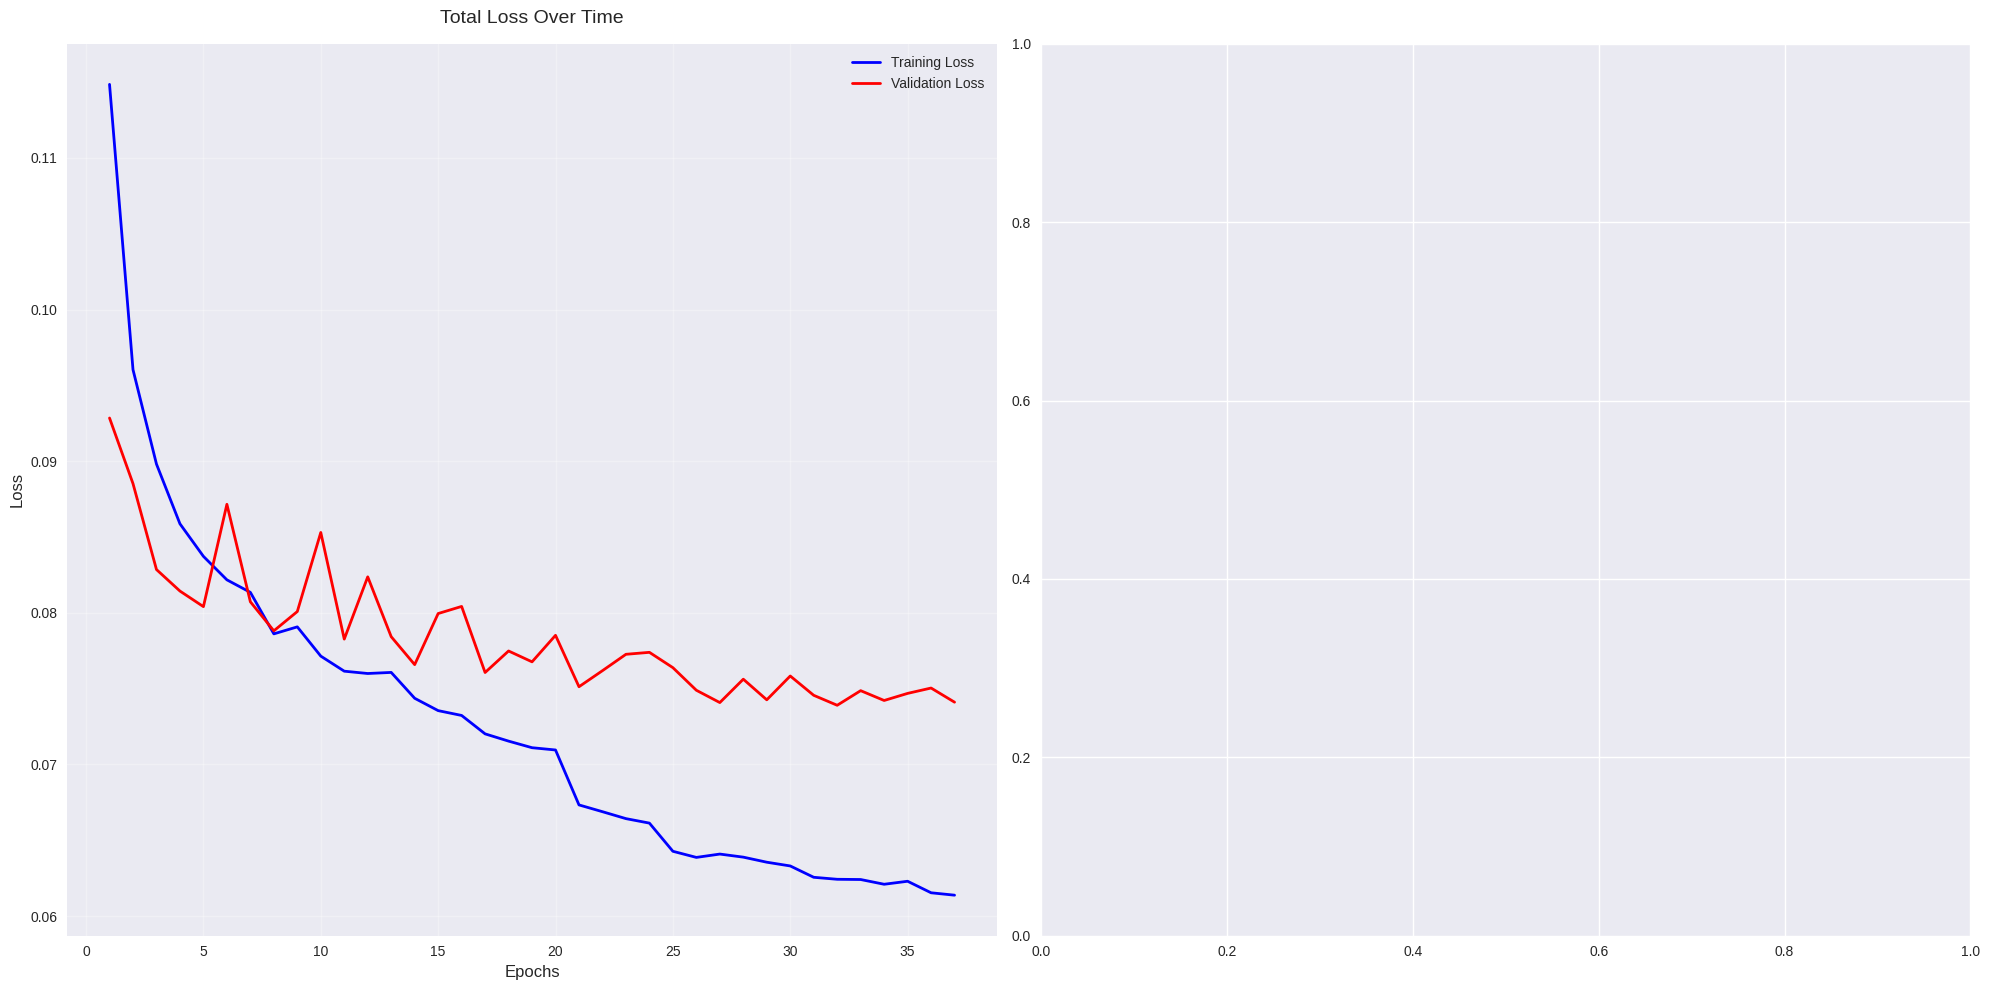

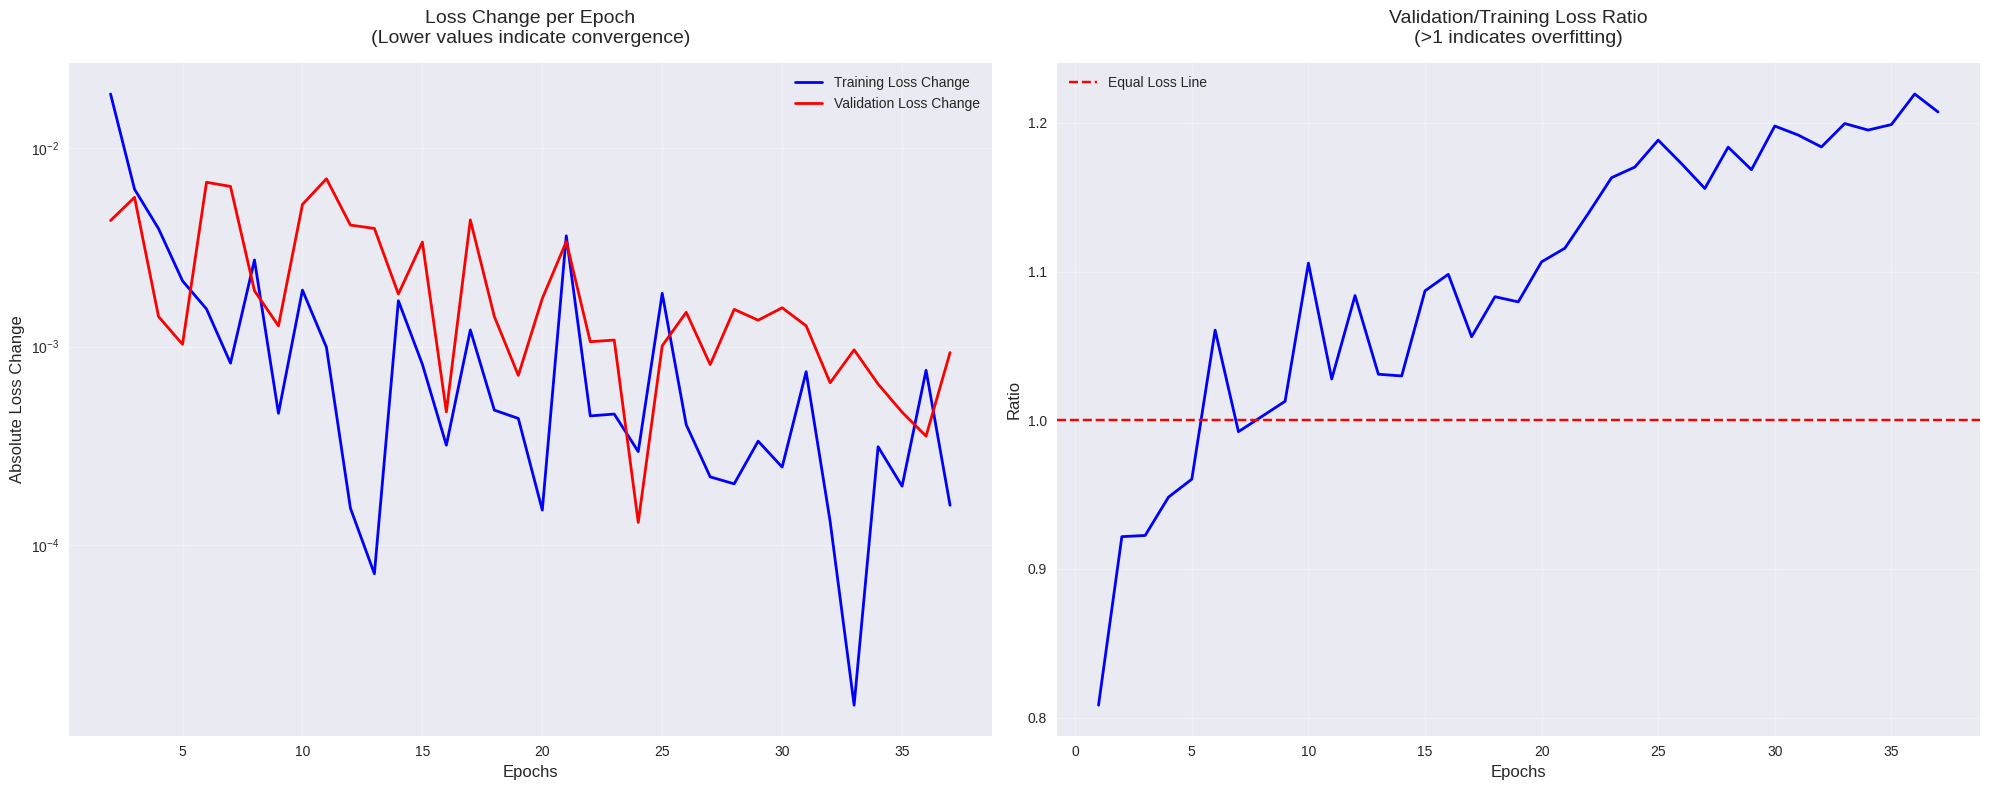


=== Training Summary ===
Total epochs trained: 37
Initial training loss: 0.1149
Final training loss: 0.0614
Best training loss: 0.0614 at epoch 37

Validation Metrics:
Initial validation loss: 0.0928
Final validation loss: 0.0741
Best validation loss: 0.0739 at epoch 32

=== Convergence Analysis ===
Loss stability (last 5 epochs): 0.000413
Validation loss stability: 0.000363

Total loss improvement: 46.56%


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

def plot_training_metrics():
    # Path to the training history JSON file
    history_path = "/content/drive/MyDrive/Data/OutputDeepSESR/training_history.json"

    # Load training history
    print("Loading training history...")
    with open(history_path, 'r') as f:
        history = json.load(f)

    # Get number of epochs
    epochs = range(1, len(history['loss']) + 1)

    # Set style for better visualization in Colab
    plt.style.use('seaborn')

    # First set of plots
    fig = plt.figure(figsize=(20, 10))

    # 1. Total Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
    if 'val_loss' in history:
        plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Total Loss Over Time', fontsize=14, pad=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # 2. Learning Rate
    plt.subplot(1, 2, 2)
    if 'lr' in history:
        plt.plot(epochs, history['lr'], 'g-', linewidth=2)
        plt.title('Learning Rate Over Time', fontsize=14, pad=15)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Learning Rate', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Additional Analysis
    plt.figure(figsize=(20, 8))

    # 1. Loss Change Rate
    plt.subplot(1, 2, 1)
    loss_change = np.diff(history['loss'])
    plt.plot(epochs[1:], np.abs(loss_change), 'b-', label='Training Loss Change', linewidth=2)
    if 'val_loss' in history:
        val_loss_change = np.diff(history['val_loss'])
        plt.plot(epochs[1:], np.abs(val_loss_change), 'r-', label='Validation Loss Change', linewidth=2)
    plt.title('Loss Change per Epoch\n(Lower values indicate convergence)', fontsize=14, pad=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Absolute Loss Change', fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # 2. Validation vs Training Loss Ratio
    plt.subplot(1, 2, 2)
    if 'val_loss' in history:
        val_train_ratio = np.array(history['val_loss']) / np.array(history['loss'])
        plt.plot(epochs, val_train_ratio, 'b-', linewidth=2)
        plt.axhline(y=1.0, color='r', linestyle='--', label='Equal Loss Line')
        plt.title('Validation/Training Loss Ratio\n(>1 indicates overfitting)', fontsize=14, pad=15)
    else:
        plt.title('Validation Loss Not Available', fontsize=14, pad=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print Training Summary
    print("\n=== Training Summary ===")
    print(f"Total epochs trained: {len(epochs)}")
    print(f"Initial training loss: {history['loss'][0]:.4f}")
    print(f"Final training loss: {history['loss'][-1]:.4f}")
    print(f"Best training loss: {min(history['loss']):.4f} at epoch {np.argmin(history['loss'])+1}")

    if 'val_loss' in history:
        print(f"\nValidation Metrics:")
        print(f"Initial validation loss: {history['val_loss'][0]:.4f}")
        print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
        print(f"Best validation loss: {min(history['val_loss']):.4f} at epoch {np.argmin(history['val_loss'])+1}")

    # Convergence Analysis
    final_window = min(5, len(epochs))  # Use smaller window if fewer epochs
    loss_stability = np.std(history['loss'][-final_window:])

    print(f"\n=== Convergence Analysis ===")
    print(f"Loss stability (last {final_window} epochs): {loss_stability:.6f}")

    if 'val_loss' in history:
        val_loss_stability = np.std(history['val_loss'][-final_window:])
        print(f"Validation loss stability: {val_loss_stability:.6f}")

    # Learning Rate Analysis
    if 'lr' in history:
        print("\n=== Learning Rate Analysis ===")
        print(f"Initial learning rate: {history['lr'][0]:.6f}")
        print(f"Final learning rate: {history['lr'][-1]:.6f}")
        lr_changes = sum(np.diff(history['lr']) < 0)
        if lr_changes > 0:
            print(f"Learning rate reduced {lr_changes} times")

    # Calculate improvement
    total_improvement = ((history['loss'][0] - history['loss'][-1]) / history['loss'][0]) * 100
    print(f"\nTotal loss improvement: {total_improvement:.2f}%")

# Run the visualization
plot_training_metrics()